<a href="https://colab.research.google.com/github/ecastro159/Real-Time-ML/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Music Classification**
 **Real Time ML Final Project**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pathlib
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


**Setting up Data file paths**

In [4]:
import pandas as pd
from pathlib import Path
import glob

#Point to .wav files and metadate files

download_path = Path.cwd()/'/content/drive/MyDrive/Colab Notebooks/Real_ML_Project/Data'
path = '/content/drive/MyDrive/Colab Notebooks/Real_ML_Project/Data/genres_original'
single_path = '/content/drive/MyDrive/Colab Notebooks/Real_ML_Project/Data/genres_original/rock/rock.00054.wav'
second_path = '/content/drive/MyDrive/Colab Notebooks/Real_ML_Project/Data/genres_original/country/country.00054.wav'
# Read metadata file
metadata_file = download_path/'features_30_sec.csv'
df = pd.read_csv(metadata_file)
df.head()

# Read all 
files = glob.glob(str(path) + '/*/*.wav')


df['relative_path'] = files

df = df[['relative_path', 'ClassID']]

df.head()


,relative_path,ClassID
0,/content/drive/MyDrive/Colab Notebooks/Real_ML...,0
1,/content/drive/MyDrive/Colab Notebooks/Real_ML...,0
2,/content/drive/MyDrive/Colab Notebooks/Real_ML...,0
3,/content/drive/MyDrive/Colab Notebooks/Real_ML...,0
4,/content/drive/MyDrive/Colab Notebooks/Real_ML...,0


**Taking a closer look at the audio files**

Shape of waveform: torch.Size([1, 661794])
Shape of sample rate: 22050
tensor([[-0.0382, -0.0182, -0.0225,  ...,  0.0019,  0.0087,  0.0166]])


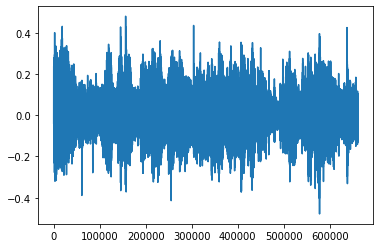

In [ ]:
import matplotlib.pyplot as plt


waveform, sr = torchaudio.load(single_path)
print("Shape of waveform: {}". format(waveform.size()))
print("Shape of sample rate: {}".format(sr))
plt.figure()
plt.plot(waveform.t().numpy())
print(waveform)

Shape of spectrogram: torch.Size([1, 64, 1293])


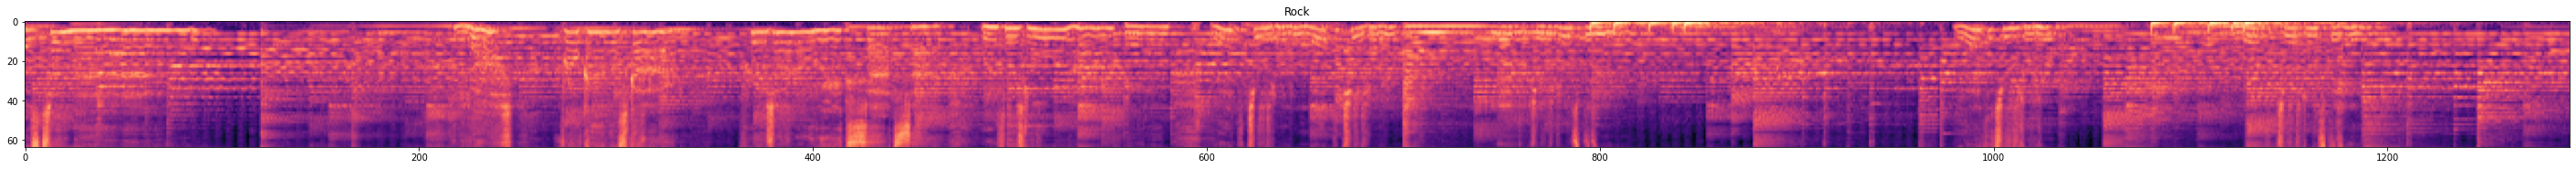

In [ ]:
spec = transforms.MelSpectrogram(sr, n_fft=1025,hop_length=512, n_mels=64)(waveform)
print("Shape of spectrogram: {}".format(spec.size()))
plt.figure(figsize=(50,50))
plt.title('Rock')
plt.imshow(spec.log2()[0,:,:].detach().numpy(), cmap='magma')


Shape of waveform: torch.Size([1, 661794])
Shape of sample rate: 22050


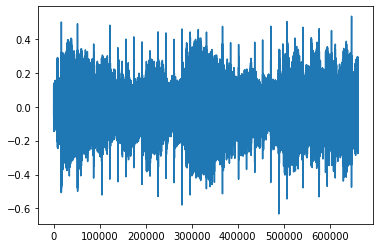

In [ ]:
country_waveform, r_sr = torchaudio.load(second_path)
print("Shape of waveform: {}". format(waveform.size()))
print("Shape of sample rate: {}".format(sr))

plt.figure()
plt.plot(country_waveform.t().numpy())

Shape of spectrogram: torch.Size([1, 64, 1293])


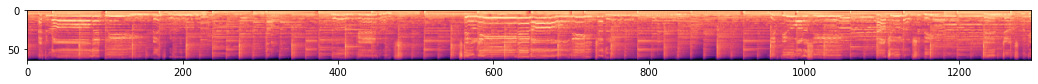

In [ ]:
spec = transforms.MelSpectrogram(r_sr, n_fft=1025, hop_length=None, n_mels=64)(country_waveform)
print("Shape of spectrogram: {}".format(spec.size()))
plt.figure(figsize=(18,10))
plt.imshow(spec.log2()[0,:,:].detach().numpy(), cmap='magma')


**Load an audio file. Return the signal as a tensor and the sample rate**

In [ ]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():


# Opening audio files
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

# Resample audio files
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))


# Resize audio files to same lenght
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

# Simple time shift
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)


  

  # Generate a Spectrogram

  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)


  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

# Change number of channels 
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]

    return ((resig, sr))

**Load Files and convert them**

In [ ]:
# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 661794
    self.sr = 22050
    self.channel = 1
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    audio_file =self.df.loc[idx, 'relative_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'ClassID']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

**Create training and validation set**

In [ ]:
from torch.utils.data import random_split

myds = SoundDS(df, path)
print()

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

kwargs = {'num_workers': 2, 'pin_memory': True} if device == 'cuda' else {}



# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True, **kwargs)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, **kwargs)

**Model**

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# # Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 2)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.drp = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(16, 32, 2)
        self.conv3 = nn.Conv2d(32, 64, 2)
        self.conv4 = nn.Conv2d(64, 128, 2)
        self.conv5 = nn.Conv2d(128, 64, 2)
        self.pool2 = nn.MaxPool2d(3, stride=2)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 10)


    def forward(self, x):
        x = self.drp(self.pool1(F.relu(self.conv1(x))))
        x = self.drp(self.pool1(F.relu(self.conv2(x))))
        x = self.drp(self.pool1(F.relu(self.conv3(x))))
        x = self.drp(self.pool1(F.relu(self.conv4(x))))
        x = self.drp(self.pool2(F.relu(self.conv5(x))))
        #size = torch.flatten(x).shape[0]
        #print(x.shape)
        x = x.view(-1, 64)
        #x = x.unsqueeze_(1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# # myModel = AudioClassifier()
# alexModel = Net()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# myModel = alexModel.to(device)
# # Check that it is on Cuda
# next(alexModel.parameters()).device

**Training Loop**

In [ ]:
from tqdm import tqdm


def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in tqdm(enumerate(train_dl)):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')






In [ ]:
num_epochs=2   # Just for demo
training(myModel, train_dl, num_epochs)

50it [18:00, 21.61s/it]


Epoch: 0, Loss: 2.16, Accuracy: 0.18


50it [10:01, 12.04s/it]

Epoch: 1, Loss: 2.05, Accuracy: 0.22
Finished Training


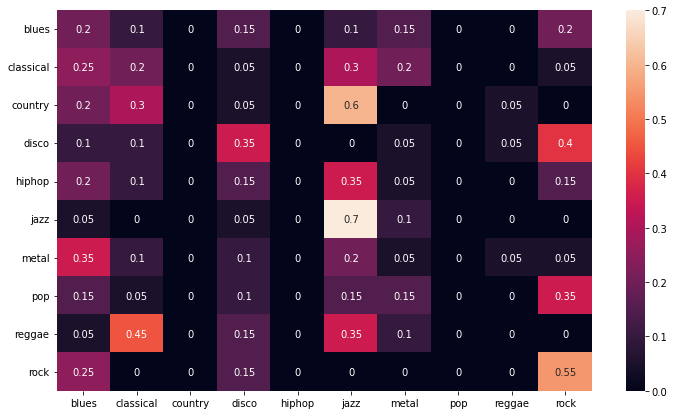

In [ ]:
# ----------------------------
# Inference
# ----------------------------
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np


y_pred = []
y_true = []

def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)
      output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
      y_pred.extend(output) # Save Prediction

      labels = labels.data.cpu().numpy()
      y_true.extend(labels) # Save Truth



    classes = ('blues', 'classical', 'country', 'disco', 'hiphop',
        'jazz', 'metal', 'pop', 'reggae', 'rock')
    
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')

inference(myModel, val_dl)